# Test File - Pushing to Git

Git use is successful - set up and saving ok.

# Aims for this notebook:
- Import data from the scan feature in ImageJ
- Plot data (normalise) and fit to Gaussians to find waist values 
- Plot all waist values against z distance to extropolate back and find w0

## Import all useful libraries / tools

In [158]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from os import listdir
import scipy

## Import Data

Function below that takes path and returns distances and amplitudes from all csv files in that folder, as np.ndarrays in a big list

In [159]:
def import_data(global_path):

    # Function which finds filenames of csvs in a folder
    def find_csv_filenames( path_to_dir, suffix=".csv" ):
        filenames = listdir(path_to_dir)
        return [ filename for filename in filenames if filename.endswith( suffix ) ]

    # the list of files in the folder
    files_list = find_csv_filenames(global_path)

    # empty lists to put values in
    distances = []
    amps = []

    # loop through file names in directory
    for f in range(len(files_list)):

        # Import an execl sheet as dataframe, called 'Values1'
        # NB: Image J seems to have saved this 'excel sheet' as a csv file
        df_test = pd.read_csv(global_path + files_list[f])

        # Extracing a column by title and converting data to array
        distances.append(np.array(df_test['Distance_(microns)']))
        amps.append(np.array(df_test['Gray_Value']))

    # returning arrays within two big lists
    return distances, amps

In [160]:
# Define useful path to data
globalpath = "D:/1. L4 Project/Fibres/2023-11-28/Data-Photo2/"

In [161]:
distances, amplitudes = import_data(globalpath)

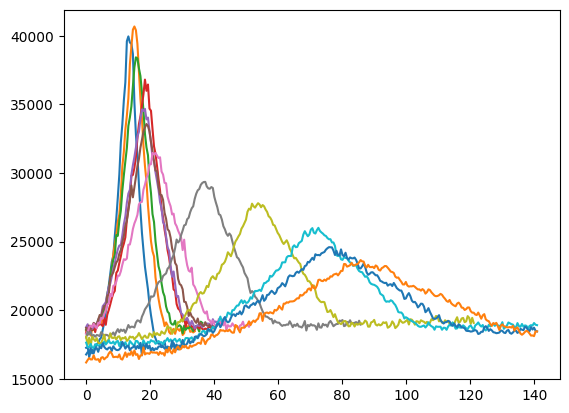

In [162]:
for i in range(12):
    plt.plot(distances[i][0:300], amplitudes[i][0:300])

plt.show()

## Normalise, cut down data

In [163]:
def data_trim(distances_, amplitudes_, cutoff):

    '''A function to tidy up the raw gaussian data. Implements measures to normalise and trasform data such that
    the only fitting parameter becomes the waist of the beam, W. '''

    new_distances = []
    new_amps = [] # some empty lists to append to at the end of the loop

    for j in range(len(distances_)): # iterate through distances (amps)

        # Get rid of vertical offset - to reduce a fitting parameter
        subt_amp = amplitudes_[j] - np.min(amplitudes_[j])

        # Normalise data by its maximum value
        norm_amp = subt_amp / np.max(subt_amp)

        dist_max = 0 # to add to later

        # Move data so centred on zero - reduce fitting params further
        for i in range(norm_amp.size):
            if norm_amp[i] == np.max(norm_amp):
                dist_max = distances_[j][i]

        shifted_distances = distances_[j] - dist_max

        cut_dist = 0
        cut_amps = 0

        if len(shifted_distances) > cutoff:
            cut_dist = shifted_distances[0:cutoff]
            cut_amps = norm_amp[0:cutoff]

            # Add adjusted data set to the new large lists
            new_distances.append(cut_dist)
            new_amps.append(cut_amps)

        else:
            new_distances.append(shifted_distances)
            new_amps.append(norm_amp)

    return new_distances, new_amps

In [164]:
all_distances, all_amps = data_trim(distances, amplitudes, 310)

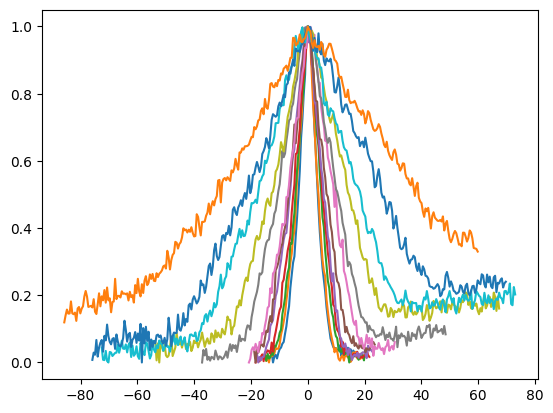

In [165]:
for i in range(12):
    plt.plot(all_distances[i], all_amps[i])

## Fit Data

In [166]:
# Redefining x and y
x = all_distances[0]
y = all_amps[0]

Defining useful functions - using chi squared and fit_labs, previously written

In [167]:
def chi_squared(model_params, model, x_data, y_data, y_error):
    return np.sum(((y_data - model(x_data, *model_params))/y_error)**2)

In [168]:
def fit_labs(xdata,ydata, yerrors, function, initial_guess):

    dof = np.size(xdata) - np.size(initial_guess) ## degrees of freedom

    if np.size(yerrors) == 1:

        yerr_extended = np.zeros(np.size(xdata))
        for i in range(np.size(yerr_extended)):
            yerr_extended[i] = yerrors

        parameters, covariance = curve_fit(function, xdata, ydata, sigma = yerr_extended, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    if yerrors == 0:

        parameters, covariance = curve_fit(function, xdata, ydata, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    else:
    
        parameters, covariance = curve_fit(function, xdata, ydata, sigma = yerrors, absolute_sigma = True, p0 = initial_guess, maxfev = 50000)

    perrors = np.sqrt(np.diag(covariance))

    # chisq_min = chi_squared(parameters,
    #                     function, 
    #                     xdata, 
    #                     ydata, 
    #                     yerrors) 
    
    # chisq_reduced = chisq_min / dof

    # p_value = scipy.stats.chi2.sf(chisq_min, dof)

    yfit = function(xdata, *parameters)

    return yfit, parameters, perrors

In [169]:
def Gauss(x, W): ### Defien Gaussian with FOUR parameters 
    y = np.exp((-2*(x**2) / W**2))
    return y

[ 6.302954    6.97707769  8.12238891  9.18495369 10.65012309 12.05584944
 14.42953366 18.7096418  25.1330636  33.12935024 44.5608235  64.53753296]


c:\Users\abiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:828: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
c:\Users\abiga\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_minpack_py.py:504: RuntimeWarning: invalid value encountered in multiply
  return transform * (func(xdata, *params) - ydata)


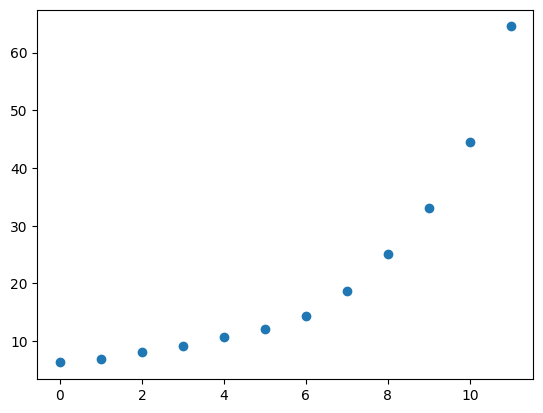

In [174]:
waists = np.zeros(len(all_distances))
y_fits = []
waist_errors = np.zeros(len(all_distances))


for i in range(len(all_distances)):
    singlefit, waists[i], waist_errors[i] = fit_labs(all_distances[i],all_amps[i], 0, Gauss, 10)
    y_fits.append(singlefit)

print(waists)

plt.scatter(np.arange(12),waists)

[6.30294511] [2.11362709]


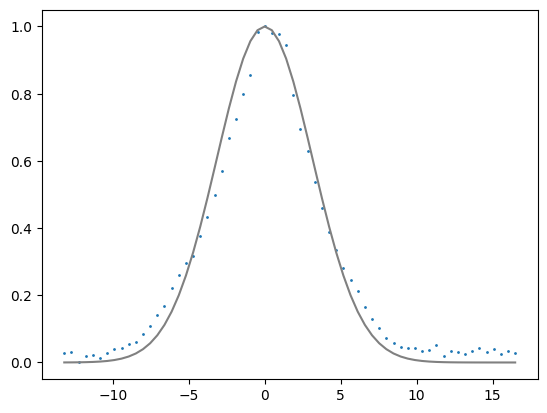

In [ ]:
# plt.scatter(x,y, s = 1)
# plt.plot(x,yfit, color = 'grey')
# print(parameters, perrors)